In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

from sklearn.preprocessing import MinMaxScaler # StandardScaler

from sklearn.metrics import mean_squared_error

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from check import handle_outliers_iqr

import matplotlib.pyplot as plt

import joblib

In [2]:
pd.set_option('display.float_format', '{:.3f}'.format)

In [3]:
j = pd.read_csv('data/J(배).csv', header=0)
j.head()

,date,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
0,2019-10-18 19:48:00,2.287,2.336,0.000,0,136.368,0,0.000,410.256
1,2019-10-18 19:49:00,2.290,2.332,0.000,0,134.696,0,0.000,430.988
2,2019-10-18 19:50:00,2.284,2.336,0.000,0,137.882,0,0.000,440.624
3,2019-10-18 19:51:00,2.290,2.331,0.000,0,138.478,0,0.000,453.675
4,2019-10-18 19:52:00,2.284,2.330,0.000,0,134.451,0,0.000,448.864


In [4]:
j.describe()

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
count,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000,1684763.000
mean,2.833,2.957,7651.998,150.048,334.790,74.439,6594.258,304.030
std,0.851,0.618,874445.828,17147.015,152.779,8506.669,753570.709,98.444
min,0.000,0.000,0.000,0.000,-966.718,0.000,0.000,-119.992
25%,2.713,2.762,0.000,0.000,259.000,0.000,0.000,231.979
50%,3.031,3.049,0.000,0.000,300.200,0.000,0.000,308.723
75%,3.313,3.316,0.000,0.000,367.000,0.000,0.000,369.000
max,4.019,4.069,99936460.000,1959678.000,2113.655,972199.000,86124350.000,1391.800


In [5]:
j['date'] = pd.to_datetime(j['date'])
j.set_index('date', inplace=True)

In [6]:
j = j.resample('h').mean()
j.head(), j.tail()

(                     height1  height2  in_valve1  in_valve2  in_flow  \
 date                                                                   
 2019-10-18 19:00:00    2.278    2.325      0.000      0.000  135.767   
 2019-10-18 20:00:00    2.325    2.368      0.000      0.000  451.579   
 2019-10-18 21:00:00    2.387    2.424      0.000      0.000  285.715   
 2019-10-18 22:00:00    2.389    2.421      0.000      0.000  269.691   
 2019-10-18 23:00:00    2.376    2.408      0.000      0.000  175.643   
 
                      out_valve1  out_valve2  out_flow  
 date                                                   
 2019-10-18 19:00:00       0.000       0.000   444.767  
 2019-10-18 20:00:00       0.000       0.000   352.897  
 2019-10-18 21:00:00       0.000       0.000   426.186  
 2019-10-18 22:00:00       0.000       0.000   336.389  
 2019-10-18 23:00:00       0.000       0.000   320.777  ,
                      height1  height2  in_valve1  in_valve2  in_flow  \
 date         

In [7]:
j.isna().sum()

height1       0
height2       0
in_valve1     0
in_valve2     0
in_flow       0
out_valve1    0
out_valve2    0
out_flow      0
dtype: int64

In [8]:
start_date = pd.Timestamp('2019-10-18 20:00:00')
end_date = pd.Timestamp('2022-06-30 23:59:00')

# 주어진 기간 내의 데이터를 sample로 설정
sample_df = j[(j.index >= start_date) & (j.index <= end_date)]

sample_df

,height1,height2,in_valve1,in_valve2,in_flow,out_valve1,out_valve2,out_flow
date,,,,,,,,
2019-10-18 20:00:00,2.325,2.368,0.000,0.000,451.579,0.000,0.000,352.897
2019-10-18 21:00:00,2.387,2.424,0.000,0.000,285.715,0.000,0.000,426.186
2019-10-18 22:00:00,2.389,2.421,0.000,0.000,269.691,0.000,0.000,336.389
2019-10-18 23:00:00,2.376,2.408,0.000,0.000,175.643,0.000,0.000,320.777
2019-10-19 00:00:00,2.416,2.464,0.000,0.000,381.217,0.000,0.000,293.171
...,...,...,...,...,...,...,...,...
2022-06-30 19:00:00,3.129,3.114,0.000,0.000,245.008,0.000,0.000,406.098
2022-06-30 20:00:00,2.987,2.977,0.000,0.000,244.290,0.000,0.000,434.142
2022-06-30 21:00:00,2.836,2.830,0.000,0.000,245.970,0.000,0.000,428.195


In [9]:
type(sample_df)

pandas.core.frame.DataFrame

In [10]:
train_start = start_date
train_end = pd.Timestamp('2021-08-31 23:00:00')
val_start = pd.Timestamp('2021-09-01 00:00:00')
val_end = pd.Timestamp('2022-01-31 23:00:00')
test_start = pd.Timestamp('2022-02-01 00:00:00')
test_end = end_date

In [11]:
train_set = sample_df.loc[train_start:train_end]
val_set = sample_df.loc[val_start:val_end]
test_set = sample_df.loc[test_start:test_end]

train_set.shape, val_set.shape, test_set.shape

((16396, 8), (3672, 8), (3600, 8))

In [12]:
# NaN 값 확인
print("NaN values in train_data before scaling:", train_set.isna().sum().sum())
print("NaN values in val_data before scaling:", val_set.isna().sum().sum())
print("NaN values in test_data before scaling:", test_set.isna().sum().sum())

NaN values in train_data before scaling: 0
NaN values in val_data before scaling: 0
NaN values in test_data before scaling: 0


In [13]:
features = ['height1', 'height2', 'in_flow']
target = 'out_flow'

In [14]:
train_features = train_set[features]
train_target = train_set[[target]]
val_features = val_set[features]
val_target = val_set[[target]]
test_features = test_set[features]
test_target = test_set[[target]]

print(f'train_features의 shape', train_features.shape)
print(f'train_target의 shape', train_target.shape)
print(f'val_features의 shape', val_features.shape)
print(f'val_target의 shape', val_target.shape)
print(f'test_features의 shape', test_features.shape)
print(f'test_target의 shape', test_target.shape)

train_features의 shape (16396, 3)
train_target의 shape (16396, 1)
val_features의 shape (3672, 3)
val_target의 shape (3672, 1)
test_features의 shape (3600, 3)
test_target의 shape (3600, 1)


In [15]:
ft_scaler = MinMaxScaler()
tg_scaler = MinMaxScaler()

scaled_train_features = ft_scaler.fit_transform(train_features)
scaled_train_target = tg_scaler.fit_transform(train_target)

scaled_val_features = ft_scaler.transform(val_features)
scaled_val_target = tg_scaler.transform(val_target)

scaled_test_features = ft_scaler.transform(test_features)
scaled_test_target = tg_scaler.transform(test_target)

print(f'scaled_train_features의 shape', scaled_train_features.shape)
print(f'scaled_train_target의 shape', scaled_train_target.shape)
print(f'scaled_val_features의 shape', scaled_val_features.shape)
print(f'scaled_val_target의 shape', scaled_val_target.shape)
print(f'scaled_test_features의 shape',scaled_test_features.shape)
print(f'scaled_test_target의 shape', scaled_test_target.shape)

scaled_train_features의 shape (16396, 3)
scaled_train_target의 shape (16396, 1)
scaled_val_features의 shape (3672, 3)
scaled_val_target의 shape (3672, 1)
scaled_test_features의 shape (3600, 3)
scaled_test_target의 shape (3600, 1)


In [16]:
def create_sequences(features, target, seq_length):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 48
X_train, y_train = create_sequences(scaled_train_features, scaled_train_target, seq_length)
X_val, y_val = create_sequences(scaled_val_features, scaled_val_target, seq_length)
X_test, y_test = create_sequences(scaled_test_features, scaled_test_target, seq_length)

print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_train.shape}')
print(f'y_test : {y_test.shape}')

X_train : (16348, 48, 3)
y_train : (16348, 1)
X_val : (3624, 48, 3)
y_val : (3624, 1)
X_test : (16348, 48, 3)
y_test : (3552, 1)


In [17]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x): # defines forward pass of the neural network
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
input_size = 3
num_layers = 3
hidden_size = 64
output_size = 1

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
model = LSTMModel(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.005)

print(model)

LSTMModel(
  (lstm): LSTM(3, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [21]:
batch_size = 64
# Create DataLoader for batch training
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
num_epochs = 70
patience = 10
verbose = 10

train_hist =[]
val_hist =[]

for epoch in range(num_epochs):
    total_train_loss = 0.0
    total_val_loss = 0.0

    # Training
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        predictions = model(batch_X)
        loss = loss_fn(predictions, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        for batch_X_val, batch_y_val in val_loader:
            batch_X_val, batch_y_val = batch_X_val.to(device), batch_y_val.to(device)
            predictions_val = model(batch_X_val)
            val_loss = loss_fn(predictions_val, batch_y_val)
            total_val_loss += val_loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    average_val_loss = total_val_loss / len(val_loader)

    train_hist.append(average_train_loss)
    val_hist.append(average_val_loss)
    
    # verbose 주기마다 loss 출력
    if (epoch + 1) % verbose == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

    # patience 주기마다 early stopping 여부 확인
    if (epoch + 1) % patience == 0 and epoch + 1 != 0:
        if val_hist[-patience] < average_val_loss:
            print('\nEarly Stopping')
            break

Epoch [10/70] - Training Loss: 0.0100, Validation Loss: 0.0092
Epoch [20/70] - Training Loss: 0.0080, Validation Loss: 0.0068
Epoch [30/70] - Training Loss: 0.0073, Validation Loss: 0.0072
Epoch [40/70] - Training Loss: 0.0068, Validation Loss: 0.0067
Epoch [50/70] - Training Loss: 0.0064, Validation Loss: 0.0068
Epoch [60/70] - Training Loss: 0.0059, Validation Loss: 0.0070

Early Stopping


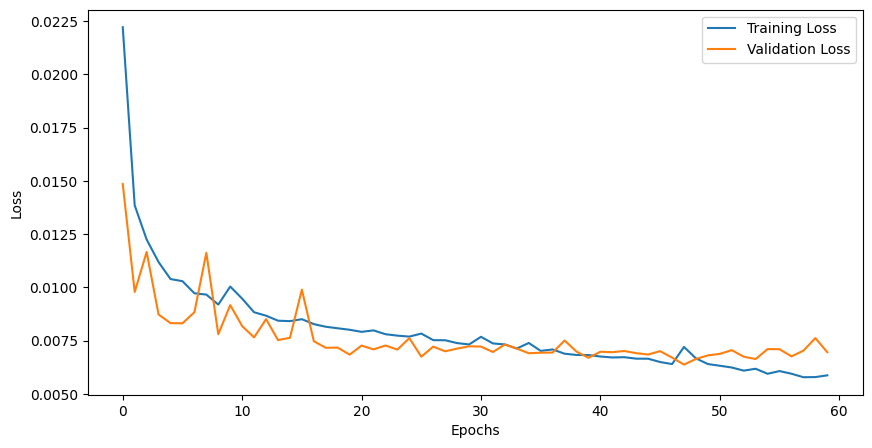

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(train_hist, label='Training Loss')
plt.plot(val_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
model.eval()
preds = []

with torch.no_grad():
    for batch_X_test, _ in test_loader:
        batch_X_test = batch_X_test.to(device)
        predictions_test = model(batch_X_test)
        preds.append(predictions_test.cpu().numpy())

preds = np.concatenate(preds, axis=0)
preds = preds.reshape(-1, 1)

# # Forecasting
# num_forecast_steps = 3

# # Use the last sequence_length data points as the starting point
# historical_data = scaled_test_target[-seq_length:]

# forecasted_values = []

# with torch.no_grad():
#     for _ in range(num_forecast_steps):
#         historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, input_size).float().to(device)
#         predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]
#         forecasted_values.append(predicted_value)
#         historical_data = np.roll(historical_data, shift=-1)
#         historical_data[-1] = predicted_value

# forecasted_values = tg_scaler.inverse_transform(np.array(forecasted_values).reshape(-1, 1))
# print("예측값", forecasted_values)

# # Generate future dates
# last_date = test_set.index[-1]
# print("마지막 날짜", last_date)
# future_dates = pd.date_range(start=last_date+pd.DateOffset(hours=1), periods=num_forecast_steps, freq='h')
# print("예측 날짜", future_dates)

# # 예측 값과 예측 날짜를 함께 출력
# for date, value in zip(future_dates, forecasted_values):
#     print(f"예측 날짜: {date}, 예측값: {value[0]}")

In [25]:
# 역변환하여 실제 값으로 변환
actual = tg_scaler.inverse_transform(y_test.cpu().numpy())
predicted = tg_scaler.inverse_transform(preds)

In [26]:
# 테스트 구간의 날짜를 가져오기
dates = test_set.index[seq_length:]

# 비교 데이터프레임 생성
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual': actual.flatten(),
    'Predicted': predicted.flatten()
})

print(comparison_df)

                    Date  Actual  Predicted
0    2022-02-03 00:00:00 196.072    165.387
1    2022-02-03 01:00:00 184.871    139.558
2    2022-02-03 02:00:00 138.798    129.335
3    2022-02-03 03:00:00 131.191    126.180
4    2022-02-03 04:00:00 133.122    127.772
...                  ...     ...        ...
3547 2022-06-30 19:00:00 406.098    401.738
3548 2022-06-30 20:00:00 434.142    403.478
3549 2022-06-30 21:00:00 428.195    387.735
3550 2022-06-30 22:00:00 364.893    347.758
3551 2022-06-30 23:00:00 312.118    293.798

[3552 rows x 3 columns]


In [27]:
rmse = np.sqrt(mean_squared_error(actual, predicted))
print(f'LSTM RMSE: {rmse:.4f}')

LSTM RMSE: 44.9264


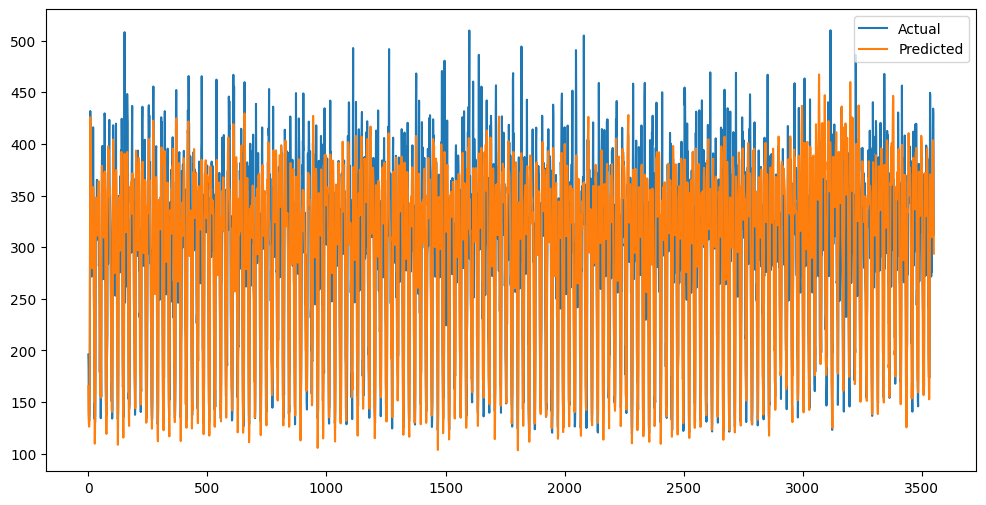

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

In [29]:
# PATH = "sample.pth"
# torch.save(model, PATH)
# print(f"Model saved to {PATH}")

In [30]:
# joblib.dump(ft_scaler, 'ft_scaler.pkl')
# joblib.dump(tg_scaler, 'tg_scaler.pkl')